In [2]:
from arg_utils import is_notebook, get_cfg
cfg = get_cfg()
# choices
classical_models = ["linear", "xgb", "rf"]
nn_models = ["mlp", "rnn", "clip", "gpt"]
# override variables to experiment in notebook
if is_notebook():    
    cfg["target_name"] = "ICP_Vital"   # ICP_Vital" , long_icp_hypertension_2
    cfg["db_name"] = "UKE"  # "UKE", "MIMIC"
    cfg["minutes"] = 60
    cfg["model_type"] = "gpt"
    
    # do experiments on:  fill_type, target_nan_quantile, train_noise_std, 
    #  min_len(increase from 20 to higher), grad_clip_val (at 1 so far), weight_decay (at 0.2 so far)
    
    cfg["fill_type"] = "none" # "pat_mean", "median", "pat_ema" "pat_ema_mask"
    #cfg["norm_method"] = None # z, or none
    
    cfg["bs"] = 16 # 8 best for rnn, 32 for GPT
    length = 128
    cfg["max_len"] = length
    cfg["min_len"] = length

    # classical model args
    cfg["flat_block_size"] = 1
    # general args
    cfg["max_epochs"] = 20
    cfg["use_nan_embed"] = True
    cfg["norm_nan_embed"] = True
    cfg["weight_decay"] = 0.2
    cfg["grad_clip_val"] = 1.0
    cfg["use_huber"] = 0
    
    cfg["lr"] = 0.001

    # rnn params
    cfg["hidden_size"] = 2048
    cfg["rnn_type"] = "gru"

    cfg["rnn_layers"] = 1
    
    # transformer stats for gpt2
    # 4.338-4.8GB with adapters and batch size 16 and 117 secs
    # 6.620GB with adapters and batch size 32 and only 100 secs
    # 11.074 GB with adapters and batch size 64 and 92 secs
    # also 4.864GB with train_mlp_norm and 127 secss
    # all get to r2 of around 0.48

    # transformer stats for gptneo1.3
    # bs8 2.1GB, 

    # rnn stats for hidden layers size 2048
    # bs 64, 5084MB, 40 secs.
    # bs 128, 8632MB, 38 secs.

    # transformer params
    cfg["mode"] = "adapters"  # "adapters", "train_mlp_norm",  "train_norm", "freeze" (does not train)
    cfg["gpt_name"] = "neo1.3"  # gpt2, neo1.3, neo2.7
    cfg["gpu"] = 1
    
    cfg["seed"] = 0
    cfg["subsample"] = 0.9
    cfg["colsample_bytree"] = 0.9
    
    
# overrides and calculated default vals
if cfg["lr"] is None:
    model_type = cfg["model_type"]
    if model_type == "clip":
        cfg["lr"] = 0.001
    elif model_type == "gpt":
        # bs 8 and gpt2 take 9.8GB with max seq len of 512
        # bs 16 with max seq len of 256
        # bs 32 with max seq len 128 only 7.4GB, good performance and fast - 6.9 if mlp_norm
        # bs 64 with len 128 and mlp_norm = 10.9GB. 9.4GB for freeze
        cfg["lr"] = 0.00005
    else:
        cfg["lr"] = 0.0001  # 0.01 works kind of for nan_embed

if cfg["fill_type"] == "none":
    cfg["use_nan_embed"] = 1
        
#cfg["val_check_interval"] = int(cfg["val_check_interval"] * (32 / cfg["batch_size"]))
    
import pytorch_lightning as pl
pl.utilities.seed.seed_everything(seed=cfg["seed"], workers=False)
locals().update(cfg)

Global seed set to 0


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(cfg["gpu"])

In [4]:
import os
        
import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from data_utils import SeqDataModule

import logging
import pytorch_lightning
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
pytorch_lightning.utilities.distributed.log.setLevel(logging.ERROR)

In [5]:
# load df
path = f'data/DB_{cfg["db_name"]}_{cfg["minutes"]}_final_df.pkl'
df = pd.read_pickle(path)

if "Bili_BGA" in df:
    print("Drop Bili")
    df = df.drop(columns=["Bili_BGA"])

/tmp/ipykernel_1696639/1720448617.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filled_df = df.copy().fillna(df.median())


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

(array([ 86.,  17., 186.,   4.,  35.,  59.,  12.,  77., 143.,  42.,   1.,
         18.,   1.,  18., 178.,  38.,   5., 125.,  14.,  62.,  72.,  73.,
         21.,  17.,  50.,  92., 110.,  81.,  15.,  76.,  89.,  27.,   6.,
          2.,   1.,   8.,   8., 135., 177.,   4.,  13.,   4.,  49.,  42.,
        175.,  13.,  76.,  20.,  34.,  52.,  62.,  46.,  21., 138.,   1.,
          2.,  89.,   2.,   1.,  23.,   2.,  53., 126.,   1., 155.,   1.,
         19.,  32.,  67.,   1.,  27.,   8., 154.,   3.,  27.,   3.,   9.,
         97., 140.,  50., 131.,   2.,  81.,   1.,  28.,  59.,   1.,  73.,
          1.,   9.,  40.,  38.,  35.,  39.,  17.,  22.,   5.,  88.,  13.,
          2.]),
 array([ 0.  ,  0.99,  1.98,  2.97,  3.96,  4.95,  5.94,  6.93,  7.92,
         8.91,  9.9 , 10.89, 11.88, 12.87, 13.86, 14.85, 15.84, 16.83,
        17.82, 18.81, 19.8 , 20.79, 21.78, 22.77, 23.76, 24.75, 25.74,
        26.73, 27.72, 28.71, 29.7 , 30.69, 31.68, 32.67, 33.66, 34.65,
        35.64, 36.63, 37.62, 38.61

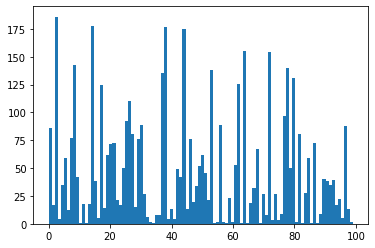

In [123]:
p = plt.hist(labels, bins=100)
p

100%|██████████| 9/9 [03:26<00:00, 22.93s/it]


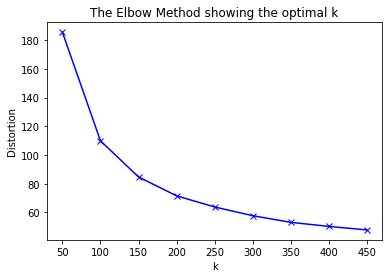

In [113]:
from scipy.spatial.distance import cdist
from tqdm import tqdm

def find_elbow(df):
    distortions = []
    K = range(50, 500, 50)
    for k in tqdm(K):
        kmeanModel = KMeans(n_clusters=k).fit(df)
        kmeanModel.fit(df)
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

find_elbow(cluster_df)

In [5]:
print(len(df))
print(df["ICP_Vital"].describe())
print(df.isna().mean().mean())
print(df["ICP_Vital"].isna().mean())

291704
count    243510.000000
mean         13.136463
std          10.522283
min         -23.000000
25%           8.000000
50%          12.000000
75%          16.000000
max         298.000000
Name: ICP_Vital, dtype: float64
0.49113061427296983
0.1652154238543181


In [6]:
# create datamodule with dataloaders
from data_utils import SeqDataModule

dm = SeqDataModule(df, db_name,
                   target_name=cfg["target_name"],
                   random_starts=cfg["random_starts"], 
                   min_len=cfg["min_len"], 
                   max_len=cfg["max_len"],
                   train_noise_std=cfg["train_noise_std"], 
                   batch_size=cfg["bs"], 
                   fill_type=cfg["fill_type"], 
                   flat_block_size=cfg["flat_block_size"],
                   target_nan_quantile=cfg["target_nan_quantile"],
                   block_size=cfg["block_size"],
                   subsample_frac=cfg["subsample_frac"],
                   )
dm.setup()

In [7]:
# test dataloader
out = next(iter(dm.train_dataloader()))
inputs, targets, lens = next(iter(dm.train_dataloader()))
#print(dm.feature_names)
print(inputs.shape, inputs.min(), inputs.max())
print(targets.shape)
print(targets[~torch.isnan(targets)].mean())
print(lens)
print(lens.float().mean(), lens.max())
# TODO: lens max and mean deviate strongly from each other - smaller ranges, increase min_len

torch.Size([1, 16, 88]) tensor(nan) tensor(nan)
torch.Size([1, 16, 1])
tensor(-7.2778)
tensor([16])
tensor(16.) tensor(16)


In [8]:
# train model on datamodule
from train_utils import train_model

models, trainers = train_model(cfg["model_type"], [dm], cfg, verbose=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Number of trainable parameters:  810815489


wandb: Currently logged in as: antonius (use `wandb login --relogin` to force relogin)


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/home/anton/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/anton/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 11.78 GiB total capacity; 10.22 GiB already allocated; 20.19 MiB free; 10.40 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import wandb
wandb.finish()

In [ ]:
#from data_utils import seq_pad_collate

#def traini(bs, num_workers, pin):
#    dl = torch.utils.data.DataLoader(data_modules[0].train_ds, batch_size=bs, num_workers=num_workers, pin_memory=pin, collate_fn=seq_pad_collate)
#    model = create_model(model_type, data_modules[0], cfg)
#    trainer = create_trainer(cfg, verbose=False)
#    trainer.fit(model, dl)

In [ ]:
from eval_utils import get_all_dfs, print_all_metrics

# eval
dl_type = "test"
#dl = external_dls["MIMIC"] # external_dls - MIMIC, eICU, UKE
calc_new_norm_stats = False
dl = None

pred_df = get_all_dfs(models, trainers, cfg["model_type"], dm.regression, dl_type=dl_type, dl=dl, calc_new_norm_stats=calc_new_norm_stats)

In [ ]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def hypertension_acc(targets, preds):
    thresh = 22
    hyper_targets = targets > thresh
    hyper_preds = preds > thresh
    hyper_acc = (hyper_targets == hyper_preds).astype(float).mean()
    return hyper_acc

In [ ]:
import importlib
import eval_utils
importlib.reload(eval_utils)
from eval_utils import get_all_dfs

if dm.regression:
    #from eval_utils import hypertension_acc
    pred_targets = pred_df["targets"].dropna()
    preds = pred_df["preds"][~pred_df["targets"].isna()]
    print("Accuracy for hypertension: ", hypertension_acc(pred_targets, np.zeros((len(pred_targets,)))))
    print("Accuracy for hypertension: ", hypertension_acc(pred_targets, preds))
    print_all_metrics(pred_df)
else:
    # general metrics
    non_na_pred_df = pred_df.dropna(subset=["targets"])
    binary_preds = non_na_pred_df["preds"] > 0.5
    targets = non_na_pred_df["targets"] 
    preds = non_na_pred_df["preds"]
    
    
    auc = sklearn.metrics.roc_auc_score(targets, preds)
    tpr, fpr, threshs = sklearn.metrics.roc_curve(targets, preds)
    plt.plot(tpr, fpr)
    plt.plot([0, 1], [0, 1], linestyle="--", color="black")
    plt.show()
    
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(targets, preds)
    plt.plot(precision, recall)
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.show()
    
    matrix = sklearn.metrics.confusion_matrix(non_na_pred_df["targets"],
                                              binary_preds)
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(matrix).plot()
    print(matrix)
    print("AUC: ", auc)
    print("Mean pred: ", pred_df["preds"].mean())
    
    #train_pred_df = get_all_dfs(models, trainers, cfg["model_type"], dm.regression, dl_type="train", dl=None, calc_new_norm_stats=False)
    #non_na_df = train_pred_df.dropna(subset=["targets"])
    #tpr, fpr, threshs = sklearn.metrics.roc_curve(non_na_df["targets"], non_na_df["preds"])
    

In [ ]:
"""
from data_utils import SeqDataModule
from eval_utils import get_all_dfs

# external performance
# read external df
if db_name == "UKE":
    ext_db_name = "MIMIC"
else:
    ext_db_name = "UKE"
path = f"data/DB_{ext_db_name}_{minutes}_final_df.pkl"
ext_df = pd.read_pickle(path)
if "Bili_BGA" in ext_df:
    print("Drop Bili")
    ext_df = ext_df.drop(columns=["Bili_BGA"])    
# create external dataloaders
dl_type = "test"
calc_new_norm_stats = False
ext_dm = SeqDataModule(ext_df, 
                            ext_db_name,
                            target_name=cfg["target_name"],
                            random_starts=cfg["random_starts"], 
                            min_len=cfg["min_len"], 
                            train_noise_std=cfg["train_noise_std"], 
                            batch_size=cfg["bs"], 
                            fill_type=cfg["fill_type"], 
                            flat_block_size=cfg["flat_block_size"],
                            target_nan_quantile=cfg["target_nan_quantile"],) 
dl = ext_dm.val_dataloader()

pred_df_ext = get_all_dfs(models, trainers, cfg["model_type"], ext_dm.regression, 
                          dl_type=dl_type, dl=dl, calc_new_norm_stats=calc_new_norm_stats)

print_all_metrics(pred_df_ext)
"""
pass
# external dataset validation

In [ ]:
if dm.regression:
    df_nona = pred_df.dropna(subset=["targets"])
    mean_pred_error = (df_nona["targets"] - dm.mean_train_target).dropna() ** 2
    ax = sns.jointplot(x="targets", y="error", data=df_nona, kind="hist", bins=100) # data=by_pat
    ax.ax_joint.scatter(df_nona["targets"], (np.ones(len(df_nona["targets"])) * dm.mean_train_target - df_nona["targets"]) ** 2, s=2, color="orange")
    plt.xlim(-20, 105)
    plt.ylim(0, 5000)

In [ ]:
if dm.regression:
    ylim = (df_nona["preds"].min() - 5, df_nona["preds"].max() + 5)
    ax = sns.jointplot(data=df_nona, x="targets", y="preds", kind="reg", ylim=ylim) # data=bypat
    min_val = df_nona["targets"].min()
    max_val = df_nona["targets"].max()
    ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2, color="black", label="Ideal model")

In [ ]:
if dm.regression:
    ax = sns.jointplot(data=df_nona, x="targets", y="preds", kind="hist", bins=100, ylim=ylim)
    print(min_val, max_val)
    # draw line of perfect correlation
    ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2)#, color="black")

In [ ]:
if dm.regression:
    #pats = df.groupby("ids").filter(lambda x: x['preds'].max() > 16)
    pats = pred_df.groupby("ids").filter(lambda x: x['targets'].mean() > 30)
    #pats = df.groupby("ids").filter(lambda x: np.sqrt(x['error'].mean()) > 30)
else:
    pats = pred_df.groupby("ids").filter(lambda x: x['preds'].mean() > 0.2)
pats = pats.groupby("ids").filter(lambda x: len(x["targets"].dropna()) > 2)

ids = pats["ids"].unique()
print(ids)
print(len(ids), "patients")
#pats

In [ ]:
from eval_utils import mape
import sklearn

pat_id = 5
model_id = 0

pat = pred_df[pred_df["ids"] == ids[pat_id]]
pat = pat[pat["model_id"] == model_id]
plt.scatter(pat["step"], pat["targets"], label="targets", color="orange")
plt.plot(pat["step"], pat["preds"], label="preds")
mean = dm.mean_train_target
print("mean average target: ", mean)
print("mean pat targets: ", pat["targets"].mean())
plt.plot([0, max(pat["step"])], [mean, mean], linewidth=1, color="black", label="mean train target", linestyle="--")
#plt.legend(location="out")
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, max(pat["step"]) + 1)
pat_nona = pat[~pat["targets"].isna()]
print("RMSE of model:", round(np.sqrt(sklearn.metrics.mean_squared_error(pat_nona["targets"], pat_nona["preds"])), 2))
print("RMSE of mean:", round(np.sqrt(sklearn.metrics.mean_squared_error(pat_nona["targets"], [mean] * len(pat_nona))), 2))
print("MAPE of model: ", round(mape(pat_nona["targets"], pat_nona["preds"]), 2))
print("MAPE of mean: ", round(mape(pat_nona["targets"], [mean] * len(pat_nona)), 2))

In [ ]:
#for i in range(len(dm.train_ds.targets)):
#    d = dm.train_ds.targets[i]
#    d = d[~torch.isnan(d)].max()
#    print(d)

## Saliency

In [ ]:
feature_names = dm.feature_names

In [ ]:
import shap


def classical_saliency(models, trainers, model_type, use_shap=False, verbose=True):
    # plot feature importance
    all_importances = []
    all_inputs = []
    
    for model, data_module in zip(models, trainers):
        if use_shap:
            explainer = shap.TreeExplainer(model)
            inputs = data_module.test_dataloader().dataset.flat_inputs
            importances = explainer.shap_values(inputs)
            all_inputs.append(inputs)
        else:
            if hasattr(model, "feature_importances_"):
                importances = model.feature_importances_
            elif hasattr(model, "coef_"):
                importances = model.coef_
        all_importances.append(importances)
    if not use_shap and verbose and hasattr(model, "importance_type"):
        print("Importance type: ", model.importance_type)
    print("importances shape ", importances.shape)
    mean_importances = np.mean(np.stack(all_importances), axis=0)
    # save
    path = f"outputs/{model_type}"
    os.makedirs("outputs", exist_ok=True)
    
    block_size = cfg["flat_block_size"]

    
    if use_shap:
        #shap.summary_plot(mean_importances, X_test, plot_type="bar")
        #shap.summary_plot(mean_importances, X_test)
        #shap.summary_plot(mean_importances)
        #input_df = pd.DataFrame(inputs, columns=feature_names)
        #shap_df = pd.DataFrame(mean_importances, columns=feature_names)
        
        #vals= np.abs(shap_values).mean(0)
        #feature_importance = pd.DataFrame(list(zip(feature_names, vals)),columns=['col_name','feature_importance_vals'])
        #feature_importance = feature_importance.sort_values(by=['feature_importance_vals'], ascending=False)
        #feature_importance.head()
                
        if verbose:
            block_feat_names = []
            for i in range(block_size):
                block_feat_names.extend([f + f"_{i}" for f in feature_names])
            
            shap.summary_plot(mean_importances, features=inputs, 
                              feature_names=block_feat_names)
            plt.savefig(path + "_shap_importances.jpg", bbox_inches='tight')
        
        
        # average over block_size/time_steps
       
        if block_size > 1:
            print(mean_importances.shape)
            mean_importances = mean_importances.reshape(-1, len(feature_names), block_size).mean(axis=-1)
            print(mean_importances.shape)


        imp_per_feat = np.abs(mean_importances).mean(axis=0)
        feat_df = pd.Series(imp_per_feat, index=feature_names)
    else:
        # make plot
        if block_size > 1:
            print(mean_importances.shape)
            mean_importances = np.abs(mean_importances.reshape(len(feature_names), block_size)).mean(axis=-1)
            print(mean_importances.shape)
        
        
        feat_df = pd.Series(mean_importances, index=feature_names)
        if verbose:
            p = feat_df.sort_values().plot.barh(figsize=(4, 25))
            p.figure.savefig(path + "_importances.jpg", bbox_inches='tight')
        
    feat_df = feat_df.sort_values(ascending=True)
    return feat_df


def reduce_feat_df(feat_df, threshold=0.2):
    # remove everything above 90% explained importance
    print(len(feat_df))
    feat_df = feat_df / feat_df.sum()
    reduced_df = feat_df[feat_df.cumsum() > threshold]
    print(len(reduced_df))
    print(reduced_df.sum())
    print(reduced_df)
    reduced_feats = list(reduced_df.index)
    return reduced_feats


In [ ]:
sal_df = classical_saliency(models, trainers, cfg["model_type"], 
                            use_shap=True, verbose=True)

In [ ]:
sal_df_normed = sal_df / sal_df.sum()
sal_df_normed.sort_values().iloc[-10:]

In [ ]:
reduced_feats = reduce_feat_df(sal_df, threshold=0.15)
reduced_feats

In [ ]:
reduced_feats

In [ ]:
from saliency import get_sal_list

sal_list = []

for model in models:
    model_saliency = get_sal_list(model, 0, perc=1.0, agg=True, ds=model.data_module.test_dataloader().dataset, ig=False)
    sal_list += model_saliency

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
mean_overall = [s.mean(0) for s in sal_list]
feat_saliency = np.sum(mean_overall, axis=0)

In [ ]:
feature_names = dm.feature_names

In [ ]:
feat_sal_df = pd.DataFrame({"sal": feat_saliency}, index = feature_names).sort_values("sal")

In [ ]:
plt.figure()
p = feat_sal_df.plot.barh(figsize = (6, 25))

In [ ]:
p.figure.savefig("importances.jpg", bbox_inches='tight')

In [ ]:
plt.show()

# Tuning

In [ ]:
from tune_utils import tune#, make_tune_plots
from data_utils import make_split

import importlib
import tune_utils
importlib.reload(tune_utils)
from tune_utils import tune

import data_utils
importlib.reload(data_utils)

In [ ]:
import logging
import pytorch_lightning

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning").setLevel(logging.ERROR)
pytorch_lightning.utilities.distributed.log.setLevel(logging.ERROR)

In [ ]:
cfg["dbs"] = ["UKE"]
cfg["k_fold"] = 0
cfg["num_splits"] = 3
cfg["flat_block_size"] = 0
cfg["n_trials"] = 15
cfg["model_type"] = "linear"
cfg["fill_type"] = "pat_mean"

cfg["max_steps"] = 300

opt_flat_block_size = False
opt_augs = False
opt_fill_type = False

In [ ]:
#storage = optuna.storages.RDBStorage(url="sqlite:///optuna.db",
#                                         engine_kwargs={"connect_args": {"timeout": 30}})
#load_study = optuna.load_study("09_17_02_39__linear_UKE_15", storage=storage)

In [ ]:
# make dev/test split to test tuning
dev_data, test_data, dev_idcs, test_idcs = make_split(seq_list, test_size=0.2)

In [ ]:
# tune
study = tune(dev_data, test_data, args, cfg, verbose=False, n_trials=cfg["n_trials"],
             opt_flat_block_size=opt_flat_block_size, opt_augs=opt_augs, opt_fill_type=opt_fill_type)

In [ ]:
#test_idcs = np.load("test_tune/09_17_02_39__linear_UKE_15/test_idcs.npy")

In [ ]:
# print key study parts
name = study.study_name
print(name)
print(study.best_trial)
best_params = study.best_params
print(best_params)

In [ ]:
from tune_utils import store_study_results
store_study_results(study, "./test_tune/", test_idcs, args)

In [ ]:
make_tune_plots(study, f"outputs/tune_results/{cfg['model_type']}_{cfg['n_trials']}")

In [ ]:
# retrain on dev/test and check performance
    
models, trainers = retrain(dev_data, test_data, best_params, args, cfg, verbose=True)

In [ ]:
cfg["k_fold"] = 0
cfg["num_splits"] = 5
models, trainers = retrain(dev_data, test_data, best_params, args, cfg, verbose=True)

In [ ]:
cfg["k_fold"] = 5
models, trainers = retrain(dev_data, test_data, best_params, args, cfg, verbose=True)

## Nested k-fold

In [ ]:
classical_models = ["xgb", "rf", "linear"]

In [ ]:
cfg["dbs"] = ["UKE"]
cfg["k_fold"] = 0
cfg["num_splits"] = 3
cfg["flat_block_size"] = 1
cfg["n_trials"] = 10

cfg["n_outer_folds"] = 3

cfg["model_type"] = "xgb"
cfg["fill_type"] = "pat_mean"

In [ ]:
from data_utils import make_fold
# outer fold
dev_data_list, test_data_list, dev_idcs, test_idcs = make_fold(seq_list, k=cfg["n_outer_folds"])

In [ ]:
# tune and store studies
studies = []
for dev_data, test_data in zip(dev_data_list, test_data_list):
    study = tune(dev_data, test_data, args, cfg, verbose=False, n_trials=cfg["n_trials"])
    # print key tune details
    name = study.study_name
    print(name)
    print(study.best_trial)
    best_params = study.best_params
    print(best_params)
    studies.append(study)

In [ ]:
metrics = []
pred_dfs = []
for tune_idx in tqdm(range(len(studies))):
    models, trainers = retrain(dev_data_list[tune_idx],
                               test_data_list[tune_idx], 
                               studies[tune_idx].best_params, 
                               args, cfg, verbose=False)
    df = get_all_dfs(models, trainers, cfg["model_type"], dl_type="test")
    #loss = print_all_metrics(df)
    loss = df.groupby("model_id").apply(lambda model_df: model_df.groupby("ids").mean()).mean()["error"]
    metrics.append(loss)
    pred_dfs.append(df)
    print(loss)

In [ ]:
print(np.mean(metrics))
print(np.std(metrics))

In [ ]:
for study in studies:
    print(study.best_value)
    print(study.best_params)
    print()

In [ ]:
[study.best_value for study in studies]

In [ ]:
metrics

In [ ]:
print(np.mean(metrics))
print(np.std(metrics))

In [ ]:
for study in studies:
    print(study.best_value)
    print(study.best_params)
    print()

In [ ]:
metrics

In [ ]:
len(studies)

In [ ]:
studies[0].best_trial